In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
import multiprocessing


# Computer characteristics
mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
mem_gib = mem_bytes / (1024.**3)
print("Computer characteristics: ")
print("RAM: %f GB" % mem_gib)
print("CORES: %d" % multiprocessing.cpu_count())


Computer characteristics: 
RAM: 7.653069 GB
CORES: 4


In [4]:
dataframe = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Check null values
print("Null values:\n", dataframe.isnull().sum())
print("\n")
countries = dataframe['Country_Region'].unique()
print("Number of different countries: ", len(countries))
print("\n")
min_date = dataframe.Date.min()
max_date = dataframe.Date.max()
print("Min date: {0}\nMax date: {1}".format(min_date, max_date))

Null values:
 Id                    0
Province_State    13200
Country_Region        0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64


Number of different countries:  180


Min date: 2020-01-22
Max date: 2020-04-05


In [5]:
# where Province_State is null we fill it with Country_Region
def fillState(state, country):
    if state == "empty":
        return country
    return state

dataframe['Province_State'].fillna("empty", inplace = True)
dataframe['Province_State'] = dataframe.loc[:,['Province_State', 'Country_Region']].apply(lambda x: fillState(x['Province_State'], x['Country_Region']), axis = 1)

test['Province_State'].fillna("empty", inplace = True)
test['Province_State'] = test.loc[:,['Province_State', 'Country_Region']].apply(lambda x: fillState(x['Province_State'], x['Country_Region']), axis = 1)

dataframe.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,Afghanistan,Afghanistan,2020-01-22,0.0,0.0
1,2,Afghanistan,Afghanistan,2020-01-23,0.0,0.0
2,3,Afghanistan,Afghanistan,2020-01-24,0.0,0.0
3,4,Afghanistan,Afghanistan,2020-01-25,0.0,0.0
4,5,Afghanistan,Afghanistan,2020-01-26,0.0,0.0


In [6]:
latest = dataframe['Date'].max()
world_confirmed = sum(dataframe[dataframe['Date'] == latest].ConfirmedCases)
print("Number of confirmed cases: ", world_confirmed)
world_fatal = sum(dataframe[dataframe['Date'] == latest].Fatalities)
print("Number of fatal cases: ", world_fatal)

Number of confirmed cases:  1271928.0
Number of fatal cases:  69369.0


In [7]:
latest_data = dataframe[dataframe['Date'] == latest]
latest_data = latest_data.drop(['Province_State'], axis = 1)

confirmed_per_country = latest_data.groupby(['Country_Region']).sum().sort_values(['ConfirmedCases'], ascending = False)
confirmed_per_country = confirmed_per_country.drop(['Id'], axis = 1)
print("First 10 countries by number of confirmed cases:\n")
print(confirmed_per_country[:10])
print("\n")
Serbia = confirmed_per_country.loc["Serbia"]
print("Confirmed cases in Serbia: ", Serbia.ConfirmedCases)
print("Fatal cases in Serbia: ", Serbia.Fatalities)

First 10 countries by number of confirmed cases:

                ConfirmedCases  Fatalities
Country_Region                            
US                    336912.0      9615.0
Spain                 131646.0     12641.0
Italy                 128948.0     15887.0
Germany               100123.0      1584.0
France                 93772.0      8093.0
China                  82602.0      3333.0
Iran                   58226.0      3603.0
United Kingdom         48434.0      4943.0
Turkey                 27069.0       574.0
Switzerland            21100.0       715.0


Confirmed cases in Serbia:  1908.0
Fatal cases in Serbia:  51.0


In [49]:
fig = go.Figure()

Serbia_confirmed = dataframe[dataframe['Country_Region'] == 'Serbia'].groupby(['Date']).sum().ConfirmedCases
# we want to see the progression from the first case in Serbia (for the first 44 days we didn't have any case)
Serbia_confirmed = Serbia_confirmed[44:]
Serbia_fatalities = dataframe[dataframe['Country_Region'] == 'Serbia'].groupby(['Date']).sum().Fatalities
Serbia_fatalities = Serbia_fatalities[44:]
date = dataframe['Date'].unique()
date = date[44:]
fig.add_trace(go.Scatter(x = date, y = Serbia_confirmed, name = "Confirmed cases"))
fig.add_trace(go.Scatter(x = date, y = Serbia_fatalities, name = "Fatal cases"))
fig.update_layout(title = "COVID-19 cases in Serbia",
                 xaxis_title = "Date",
                 yaxis_title = "Cases")


##  Global forecast

In [50]:
confirmed = dataframe.groupby(['Date']).agg({'ConfirmedCases': ['sum']})
fatalities = dataframe.groupby(['Date']).agg({'Fatalities':['sum']})

print(confirmed.head())
print(fatalities.head())

           ConfirmedCases
                      sum
Date                     
2020-01-22          554.0
2020-01-23          653.0
2020-01-24          939.0
2020-01-25         1432.0
2020-01-26         2113.0
           Fatalities
                  sum
Date                 
2020-01-22       17.0
2020-01-23       18.0
2020-01-24       26.0
2020-01-25       42.0
2020-01-26       56.0


### Forecasting number of confirmed cases globally

In [51]:
np.random.seed(7)

dataset = confirmed.values
dataset = dataset.astype('float32')

# LSTMs are sensitive to the scale of the input data, specifically 
# when sigmoid or tanh activation functions are used.
# It's good to rescale the data to the range of [0,1] (to normalize)
# we use MinMaxScaler to do that

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

# we need to estimate the skill of the model on new unseen data
# we can split the ordered dataset into train and test datasets
# 80% of the observations to train our model
# 20% for testing the model

train_size = int(len(dataset)*0.80)
test_size = len(dataset) - train_size
print(len(dataset))

train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

# convert an array of values into a dataset matrix
# first column is X at timestep t and second is y at timestep t+1
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1

trainX, trainY = create_dataset(train, look_back)
# we take testX and put it in our model and we get some values
# then we compare the values with existing values of testY
testX, testY = create_dataset(test, look_back)


# the LSTM network expects the input data (X) to be provided with a 
# specific array structure in from of: [samples, time steps, features]
# currently, our data is in the form: [samples, features] and we are
# framing the problem as one time step for each sample
# we can transform the prepared train and test input data into the expected 
# structure using numpy.reshape()

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

75
60 15


In [52]:
# one layer input
# hidden later with 4 LSTM neurons
# output layer makes a single value prediction
# sigmoid activation function (default)
# the network is trained for 100 epochs
# batch size of 1 is used


model = Sequential()
model.add(LSTM(4, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs = 100, batch_size = 1, verbose = 2)


Epoch 1/100
 - 1s - loss: 0.0029
Epoch 2/100
 - 0s - loss: 0.0021
Epoch 3/100
 - 0s - loss: 0.0020
Epoch 4/100
 - 0s - loss: 0.0019
Epoch 5/100
 - 0s - loss: 0.0019
Epoch 6/100
 - 0s - loss: 0.0018
Epoch 7/100
 - 0s - loss: 0.0017
Epoch 8/100
 - 0s - loss: 0.0016
Epoch 9/100
 - 0s - loss: 0.0015
Epoch 10/100
 - 0s - loss: 0.0014
Epoch 11/100
 - 0s - loss: 0.0013
Epoch 12/100
 - 0s - loss: 0.0012
Epoch 13/100
 - 0s - loss: 0.0010
Epoch 14/100
 - 0s - loss: 9.1046e-04
Epoch 15/100
 - 0s - loss: 7.9816e-04
Epoch 16/100
 - 0s - loss: 6.8875e-04
Epoch 17/100
 - 0s - loss: 5.9003e-04
Epoch 18/100
 - 0s - loss: 5.1018e-04
Epoch 19/100
 - 0s - loss: 4.1327e-04
Epoch 20/100
 - 0s - loss: 3.4250e-04
Epoch 21/100
 - 0s - loss: 2.7297e-04
Epoch 22/100
 - 0s - loss: 2.1003e-04
Epoch 23/100
 - 0s - loss: 1.6079e-04
Epoch 24/100
 - 0s - loss: 1.1581e-04
Epoch 25/100
 - 0s - loss: 9.2739e-05
Epoch 26/100
 - 0s - loss: 6.1821e-05
Epoch 27/100
 - 0s - loss: 4.5556e-05
Epoch 28/100
 - 0s - loss: 3.3535e

In [53]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

#invert predictions to the same units as the original data
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
print("Real values: ")
print(testY)
print("Predicted values: ")
print(testPredict)
print("Number of confirmed cases for tomorrow:", testPredict[-1])

# calculate root mean squared error
# between our predicted values(trainPredict) and given values (trainY)
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %2f RMSE' %(trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print("Test score: %2f RMSE" % (testScore))

Real values: 
[[ 377961.01825109  417951.00077191  467563.00898776  529501.01751423
   593201.01992485  660540.99107872  719951.97080901  782199.99447343
   857319.97397556  932433.96687395 1012980.99211535 1095738.96863146
  1197224.93613936]]
Predicted values: 
[[ 382529.47]
 [ 432117.38]
 [ 481091.22]
 [ 541838.25]
 [ 617247.25]
 [ 693805.56]
 [ 773124.5 ]
 [ 841371.56]
 [ 910859.1 ]
 [ 991680.6 ]
 [1068955.  ]
 [1147743.4 ]
 [1224262.  ]]
Number of confirmed cases for tomorrow: [1224262.]
Train Score: 3152.680167 RMSE
Test score: 40681.955680 RMSE


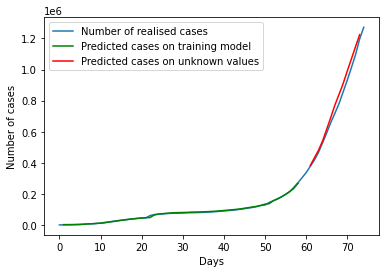

In [54]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, color = 'green')
plt.plot(testPredictPlot, color = 'red')
plt.legend(['Number of realised cases', 'Predicted cases on training model', 'Predicted cases on unknown values'])
plt.xlabel("Days")
plt.ylabel("Number of cases")
plt.show()

### Forecasting number of fatal cases globally



In [55]:
fatalities = dataframe.groupby(['Date']).agg({'Fatalities':['sum']})
#fatalities = fatalities.query("Date > '2020-02-29'")
np.random.seed(7)

dataset = fatalities.values
dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)


train_size = int(len(dataset)*0.80)
test_size = len(dataset) - train_size
#print(len(dataset))

train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

60 15


In [56]:
model_fatalities = Sequential()
model_fatalities.add(LSTM(4, input_shape = (1, look_back)))
model_fatalities.add(Dense(1))
model_fatalities.compile(loss = 'mean_squared_error', optimizer = 'adam')
model_fatalities.fit(trainX, trainY, epochs = 100, batch_size = 1, verbose = 2)

Epoch 1/100
 - 1s - loss: 0.0014
Epoch 2/100
 - 0s - loss: 0.0012
Epoch 3/100
 - 0s - loss: 0.0012
Epoch 4/100
 - 0s - loss: 0.0012
Epoch 5/100
 - 0s - loss: 0.0011
Epoch 6/100
 - 0s - loss: 0.0010
Epoch 7/100
 - 0s - loss: 0.0010
Epoch 8/100
 - 0s - loss: 9.4648e-04
Epoch 9/100
 - 0s - loss: 9.1474e-04
Epoch 10/100
 - 0s - loss: 8.2150e-04
Epoch 11/100
 - 0s - loss: 7.6897e-04
Epoch 12/100
 - 0s - loss: 7.1733e-04
Epoch 13/100
 - 0s - loss: 6.3558e-04
Epoch 14/100
 - 0s - loss: 5.6915e-04
Epoch 15/100
 - 0s - loss: 5.0515e-04
Epoch 16/100
 - 0s - loss: 4.4301e-04
Epoch 17/100
 - 0s - loss: 3.8316e-04
Epoch 18/100
 - 0s - loss: 3.3740e-04
Epoch 19/100
 - 0s - loss: 2.7990e-04
Epoch 20/100
 - 0s - loss: 2.4033e-04
Epoch 21/100
 - 0s - loss: 1.9279e-04
Epoch 22/100
 - 0s - loss: 1.5231e-04
Epoch 23/100
 - 0s - loss: 1.1870e-04
Epoch 24/100
 - 0s - loss: 8.7668e-05
Epoch 25/100
 - 0s - loss: 7.2098e-05
Epoch 26/100
 - 0s - loss: 4.9473e-05
Epoch 27/100
 - 0s - loss: 3.6051e-05
Epoch 28/10

In [57]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
print("Real values: ")
print(testY)
print("Predicted values: ")
print(testPredict)
print("Number of confirmed cases for tomorrow:", testPredict[-1])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %2f RMSE' %(trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print("Test score: %2f RMSE" % (testScore))

Real values: 
[[16498.00040469 18623.00092796 21179.00079677 23968.00088003
  27193.99934301 30648.00037542 33921.00109045 37577.99786553
  42102.99959985 46803.99780599 52977.9991775  58781.99706826
  64600.99616149]]
Predicted values: 
[[16352.04 ]
 [18562.277]
 [21139.873]
 [24261.797]
 [27678.537]
 [31620.68 ]
 [35801.85 ]
 [39701.76 ]
 [43963.27 ]
 [49065.195]
 [54135.92 ]
 [60407.582]
 [65887.04 ]]
Number of confirmed cases for tomorrow: [65887.04]
Train Score: 147.204967 RMSE
Test score: 1346.006295 RMSE


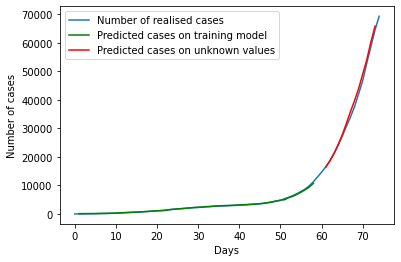

In [58]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, color = 'green')
plt.plot(testPredictPlot, color = 'red')
plt.legend(['Number of realised cases', 'Predicted cases on training model', 'Predicted cases on unknown values'])
plt.xlabel("Days")
plt.ylabel("Number of cases")
plt.show()